# PiNodeによるデータ分析

## 1. 分析用データの用意

PiNodeにサンプルデータをアップロードするコマンドが用意されています。以下のコマンドを実行してサンプルデータを用意してください

``` bash
python pinode3/scripts/upload_sample_data.py
```

これによってデータのアップロードが完了されます。

# 2. データの取得


## 2.1 画像データの取得

画像データをPiNodeから取得してsampleフォルダに格納します。

---
```
栽培対象：豆
撮影角度：平行
期間：定植から22日間
```


In [1]:
import sys
import os

# カレントディレクトリを基準にして ../scripts ディレクトリをモジュール検索パスに追加
current_dir = os.getcwd()
script_dir = os.path.abspath(os.path.join(current_dir, '..', 'scripts'))
if script_dir not in sys.path:
    sys.path.append(script_dir)

import pinode_sample_downloader as downloader

# データのダウンロード(6分ほどかかります)
downloader.download(hostname="pinode05.local")


Files from /home/pinode3/data/image/sample/ have been successfully copied to ./


In [10]:
### 画像のフォルダから動画を作成
import cv2


# 画像が保存されているフォルダのパスを入力
image_folder = "./sample"

# 出力する動画ファイル名を入力
output_video = "output_video.mp4"

# FPS (フレーム毎秒) を入力
fps = 30

# 指定フォルダ内の画像ファイル名を取得
images = [img for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
images.sort()  # ファイル名順にソート

if not images:
    raise FileNotFoundError("指定フォルダに画像が見つかりませんでした")

# 画像からフレームサイズを取得
first_image_path = os.path.join(image_folder, images[0])
frame = cv2.imread(first_image_path)
height, width, layers = frame.shape
size = (width, height)

# 動画ファイルの作成
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 動画ファイル形式
video = cv2.VideoWriter(output_video, fourcc, fps, size)

for image in images:
    image_path = os.path.join(image_folder, image)
    frame = cv2.imread(image_path)
    video.write(frame)

video.release()
print(f"{output_video} が正常に作成されました")


output_video.mp4 が正常に作成されました


In [11]:
import os
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets

# 画像が保存されているフォルダのパスを入力
image_folder = "./sample"

image_paths = sorted([img for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg'))])
image_paths = [os.path.join(image_folder, img) for img in image_paths]
images = [cv2.imread(img) for img in image_paths]

# ipywidgetsを使用してインデックスを選択するウィジェットを作成
index_slider = widgets.IntSlider(value=0, min=0, max=len(os.listdir(image_folder))-1, step=1, description='Index:')

# 画像プロット関数の定義
def plot_image_by_index(index):
    if index < 0 or index >= len(images):
        print("インデックスが範囲外です")
        return

    image = images[index]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCVのBGRからMatplotlibのRGBに変換

    plt.imshow(image)
    plt.title(f"Image at Index {index}")
    plt.axis('off')
    plt.show()

widgets.interactive(plot_image_by_index, index=index_slider)

interactive(children=(IntSlider(value=0, description='Index:', max=2695), Output()), _dom_classes=('widget-int…

# YOLO v8による葉の検出

ファインチューニングを行ったモデルを用いることで、葉の検出を実施
オリジナルのデータセットを作成したい場合は以下リンクを参考にしてください( https://qiita.com/hirekatsu0523/items/f2f0e1a0f8a9ea92d913 )

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt') # yolov8n/s/m/l/xのいずれかを指定。多クラスの検出であるほど大きいパラメータが必要
model.train(data='./dataset/data.yaml', epochs=300, batch=20) # 先ほど作成したデータセット内のyamlファイルまでのパスを指定

In [ ]:
import cv2
from ultralytics import YOLO
import pickle

model = YOLO(r'C:\Users\takuto\mineLab\PiNode3-Data-Utilization-Guide\notebooks\runs\detect\train8\weights\best.pt') # best.ptまでの相対パス
video_path = './output_video.mp4' # 対象とする動画のパス
cap = cv2.VideoCapture(video_path)
annotated_frames = []
save_results = []

def get_leaf_position(boxes):
    leaf_positions = []
    for box in boxes:
        x1, y1, x2, y2 = box
        leaf_positions.append([(x1 + x2) / 2, (y1 + y2) / 2])
    return leaf_positions

while cap.isOpened(): # フレームがある間繰り返す
    ret, frame = cap.read()
    if ret:
        results = model.track(frame, persist=True) # 物体をトラッキング
    else:
        break
    annotated_frame = results[0].plot()
    save_results.append(results[0])
    annotated_frames.append(annotated_frame)

# annotated_framesをmp4として保存
height, width, layers = annotated_frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('./annotated_video.mp4', fourcc, 30, (width, height))
for frame in annotated_frames:
    video.write(frame)
video.release()
cap.release()
pickle.dump(save_results, open('./yolo_leaf_results.pkl', 'wb'))
print('finished')

In [55]:
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets

# 画像が保存されているフォルダのパスを入力
video_path = './annotated_video.mp4'
cap = cv2.VideoCapture(video_path)

# ipywidgetsを使用してインデックスを選択するウィジェットを作成
frame_slider = widgets.IntSlider(value=0, min=0, max=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1, step=1, description='Frame:')

# 画像プロット関数の定義
def plot_image_by_index(frame):
    # 動画の指定フレームに移動
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, image = cap.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCVのBGRからMatplotlibのRGBに変換

    plt.imshow(image)
    plt.title(f"Image at frame {frame}")
    plt.axis('off')
    plt.show()

widgets.interactive(plot_image_by_index, frame=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame:', max=2695), Output()), _dom_classes=('widget-int…

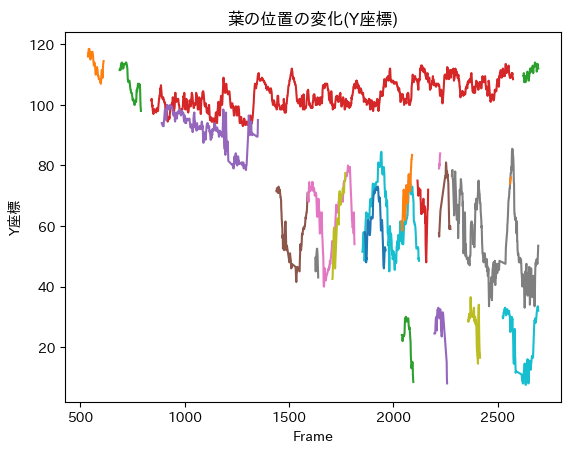

In [93]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import japanize_matplotlib

results = pickle.load(open('./yolo_leaf_results.pkl', 'rb'))

# track_idを取得
track_ids = set()
for result in results:
    track_id = result.boxes.id
    if track_id is not None:
        track_id = track_id.int().cpu().tolist()
        track_ids |= set(track_id)

# 各track_idに対するBBoxの座標を取得
df = pd.DataFrame(columns=['track_id', 'frame', 'x1', 'y1', 'x2', 'y2'])
for frame, result in enumerate(results):
    track_id = result.boxes.id
    if track_id is not None:
        track_id_list = track_id.int().cpu().tolist()
        boxes = result.boxes.xyxy.int().cpu().tolist()
        for track_id, box in zip(track_id_list, boxes):
            x1, y1, x2, y2 = box
            center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
            df_t = pd.DataFrame({'track_id': [track_id], 'frame': [frame], 'x1': [x1], 'y1': [y1], 'x2': [x2], 'y2': [y2], 'center_x': [center_x], 'center_y': [center_y]})
            df = pd.concat([df, df_t], ignore_index=True)
df_leaf = df.copy()

# 全てのtrack_idに対してプロット
for track_id in track_ids:
    df_track = df[df['track_id'] == track_id]
    # plt.plot(df_track['frame'], df_track['center_x'], label=f'Track ID: {track_id}')
    plt.plot(df_track['frame'], df_track['center_y'], label=f'Track ID: {track_id}')
plt.xlabel('Frame')
plt.ylabel('Y座標')
plt.title("葉の位置の変化(Y座標)")
plt.show()

In [57]:
import os
import cv2

# 動画と数値を合わせて動画として保存

def plot_leaf_position_video(frame):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    fig.suptitle(f"Frame {frame}")

    for track_id in track_ids:
        df_track = df[df['track_id'] == track_id]
        axes[0].plot(df_track['frame'], df_track['center_y'], label=f'Track ID: {track_id}')
    axes[0].set_xlabel('Frame')
    axes[0].set_ylabel('Y座標')
    axes[0].set_title("葉の位置の変化(Y座標)")
    axes[0].axvline(x=frame, color='red', linestyle='--')
    axes[0].set_xlim(0, len(results)+200)
    axes[0].set_ylim(0, 120)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    _, image = cap.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCVのBGRからMatplotlibのRGBに変換
    axes[1].imshow(image)
    axes[1].set_title(f"Frame {frame}")
    axes[1].axis('off')

    plt.imshow(image)
    plt.title(f"Image at frame {frame}")
    plt.axis('off')
    plt.savefig('tmp.png')
    plt.close()

# frameを0からlen(results)まで選択し動画を作成
movie_path = './leaf_position_movie.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(movie_path, fourcc, 30, (1500, 700))
for frame in range(len(results)):
    plot_leaf_position_video(frame)
    image = cv2.imread('tmp.png')
    video.write(image)
video.release()
cap.release()
os.remove('tmp.png')
print('finished')

finished


# センサデータと画像データの複合分析

<Axes: title={'center': '温度と湿度の推移'}, xlabel='_time'>

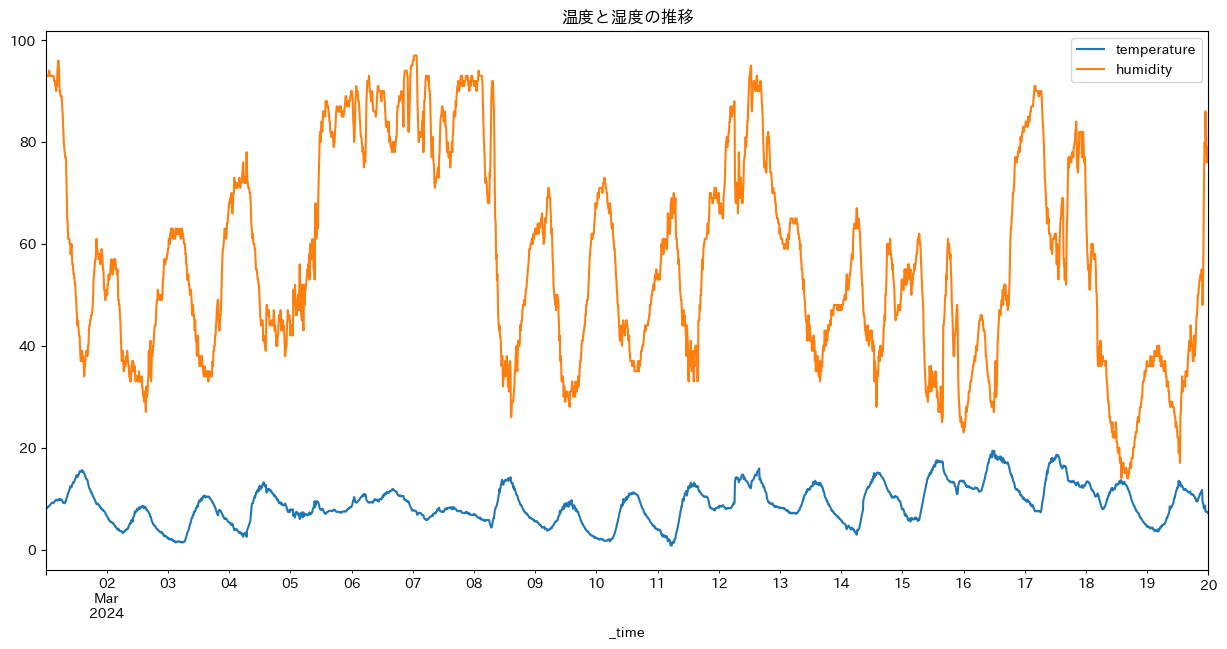

In [84]:
### センサデータの取得

from influxdb_client import InfluxDBClient

# 環境変数の設定
INFLUXDB_URL = "http://pinode05.local:8086"
INFLUXDB_TOKEN = "JhOQHJBtQ5dBx9ZZPhIegXGv51dHVlbWKAL1KNmSDdltdY83hxB3HkXZew6I2J42ZZ2hULpmxbU8OGesrTsAlg=="
INFLUXDB_ORG = "pinode"
INFLUXDB_BUCKET = "pinode"

# InfluxDBクライアントの作成
client = InfluxDBClient(url=INFLUXDB_URL, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

# クエリを設定
query = """
from(bucket: "pinode")
    |> range(start: 2024-03-01T00:00:00Z, stop: 2024-04-01T00:00:00Z)
    |> filter(fn: (r) => r._measurement == "00")
    |> filter(fn: (r) => r._field == "temperature" or r._field == "humidity")
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> yield(name: "mean")
"""


# クエリを実行
df = client.query_api().query_data_frame(query)
df_sensor = df.copy()

df.plot(x='_time', y=['temperature', 'humidity'], figsize=(15, 7), title="温度と湿度の推移")

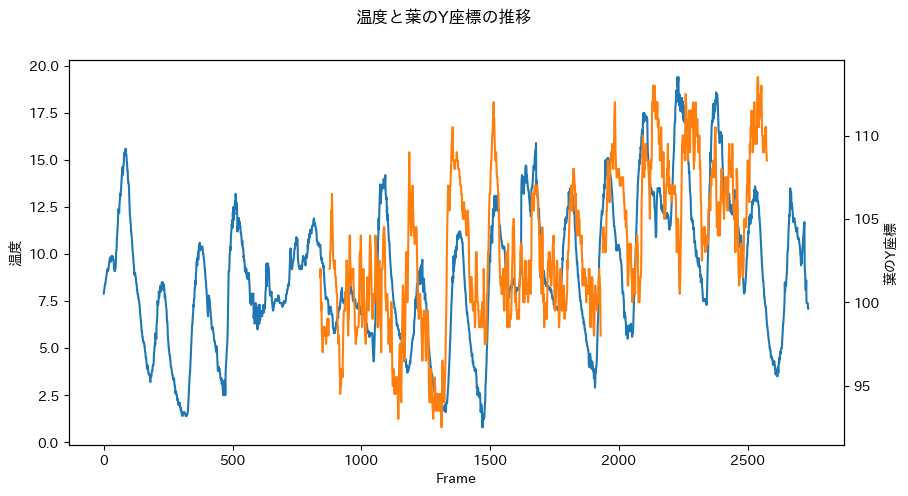

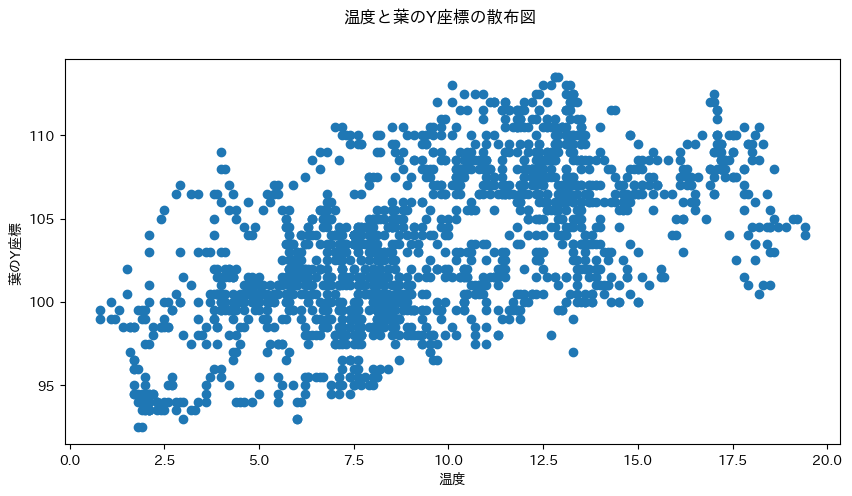

温度と葉のY座標の相関係数: 0.5911872865805735


In [111]:
df_sensor_t = df_sensor["temperature"]
df_leaf_t = df_leaf[df_leaf["track_id"] == 7].loc[:, ["frame", "center_y"]].set_index("frame")
df_leaf_temperature = pd.merge(df_sensor_t, df_leaf_t, left_index=True, right_index=True, how="outer")


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle("温度と葉のY座標の推移")
ax.plot(df_leaf_temperature['temperature'], label='温度', color='tab:blue')
ax.set_xlabel('Frame')
ax.set_ylabel('温度')
ax_right = ax.twinx()
ax_right.plot(df_leaf_temperature['center_y'], label=f'Track ID: {track_id}', color='tab:orange')
ax_right.set_ylabel('葉のY座標')
plt.show()

# 散布図の作成
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle("温度と葉のY座標の散布図")
ax.scatter(df_leaf_temperature['temperature'], df_leaf_temperature['center_y'])
ax.set_xlabel('温度')
ax.set_ylabel('葉のY座標')
plt.show()

# 相関係数の算出
correlation = df_leaf_temperature.corr().loc['temperature', 'center_y']
print(f"温度と葉のY座標の相関係数: {correlation}")